# Data 분석
- 목적 : 중고차 예상 판매가격 예측

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/car_data.csv')
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [2]:
df.Year.value_counts()
df.Fuel_Type.value_counts()
df.Seller_Type.value_counts()
df.Transmission.value_counts()
df.Owner.value_counts()

0    290
1     10
3      1
Name: Owner, dtype: int64

## Feature
- Car_Name : 차량 이름  ==> index로 설정
- Year : 차 구매년도 ==> 범주형
  - 2004년~15년까지의 value 
- Kms_Driven : 달린 거리 ==> 연속형
- Present_Price	: 현재 가격 ==> 연속형
- Fuel_Type : 기름 종류 ==> 범주형 
  - Petrol, Diesel, CNG 총 3가지 종류  
- Seller_Type : 판매자  ==> 범주형
  - Individual, Dealer
- Transmission	 : 기어 변속기 종류  ==> 범주형
  - Manual, Automatic
- Owner : 차량의 이전 소유자 수  ==> 범주형
  - 0, 1, 3
  
## Label
- Selling_Price, 중고차 판매가격으로 예측해야되는 연속적인 값

In [3]:
# name을 index로 전환
df.set_index('Car_Name', inplace = True)
df

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
Car_Name,,,,,,,,
ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0


## 연속형 Feature들 이상치 확인

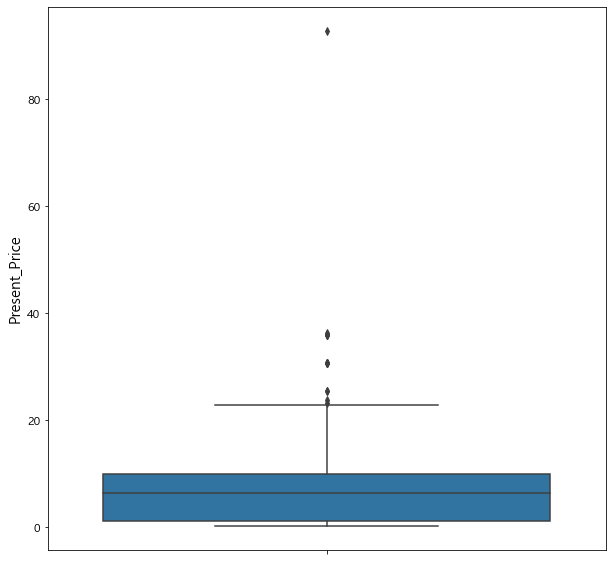

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.boxplot(y='Present_Price', data=df)
plt.show()

In [13]:
df['Present_Price'].max()

92.6

In [15]:
# 이상치 제거
df1 = df.drop(df[df['Present_Price'] >=90].index)
df1['Present_Price'].max()
df1

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
Car_Name,,,,,,,,
ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...
city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0


# Data 전처리
1. Feature, Label 분리
2. Feature
  - 범주형의 경우 pandas의 get_dummies() 함수 이용해 One-Hot Encoding
  - 연속형의 경우 앙상블을 위해 Feature Scaling  
3. 알고리즘에 따른 Data
  - KNN, linear regression은 Feature Scaling 필요
  - Random Forest, XGBoost는 필요 X

In [16]:
ohe = ['Year','Fuel_Type','Seller_Type', 'Transmission', 'Owner']
df2 = pd.get_dummies(df1, columns= ohe)     
df2
y = df2['Selling_Price']
X= df2.drop(columns='Selling_Price')

In [17]:
from sklearn.model_selection import train_test_split

# X(Feature), y(Label) 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((225, 28), (225,), (75, 28), (75,))

In [18]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-0.22151393, -0.40557936, -0.09470274, ...,  0.21566555,
        -0.20412415, -0.06681531],
       [-0.98141968,  0.3790439 , -0.09470274, ...,  0.21566555,
        -0.20412415, -0.06681531],
       [ 0.40655633, -0.54744851, -0.09470274, ...,  0.21566555,
        -0.20412415, -0.06681531],
       ...,
       [-0.05857117, -0.51270504, -0.09470274, ...,  0.21566555,
        -0.20412415, -0.06681531],
       [-0.1044914 , -0.51965374, -0.09470274, ...,  0.21566555,
        -0.20412415, -0.06681531],
       [-0.94586853, -0.45479927, -0.09470274, ...,  0.21566555,
        -0.20412415, -0.06681531]])

## 모델 선정
- 모델 선정을 위해 Ensemble Voting 방식 이용해 검증 및 상관관계 판단

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
import xgboost

In [20]:
# 각 model 생성
knn = KNeighborsRegressor(n_neighbors=5)
rf = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=0)
lr = LinearRegression()
xgb = xgboost.XGBRegressor(max_depth=2, random_state=0)

In [21]:
# 학습
knn.fit(X_train_scaled, y_train)   
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lr.fit(X_train_scaled, y_train)
# 평가
pred_train_knn = knn.predict(X_train_scaled)
pred_train_rf = rf.predict(X_train)
pred_train_xgb = xgb.predict(X_train)
pred_train_lr = lr.predict(X_train_scaled)

pred_test_knn = knn.predict(X_test_scaled)
pred_test_rf = rf.predict(X_test)
pred_test_xgb = xgb.predict(X_test)
pred_test_lr = lr.predict(X_test_scaled)

C:\Users\oj\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\oj\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\oj\anaconda3\envs\ml\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [22]:
# 평가 요소 관련 함수 정의
from sklearn.metrics import mean_squared_error, r2_score
def print_regression_metrics(y, pred, title=None):
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, pred)
    if title:
        print(title)
    print(f"MSE: {mse}, RMSE: {rmse}, R2: {r2}")

In [23]:
# train, test set 평가
print_regression_metrics(y_train, pred_train_knn, "Train KNN")
print_regression_metrics(y_test, pred_test_knn, "Test KNN")
print('-'*100)
print_regression_metrics(y_train, pred_train_rf, "Train RF")
print_regression_metrics(y_test, pred_test_rf, "Test RF")
print('-'*100)
# print_regression_metrics(y_train, pred_train_lr, "Train LogisticRegression")
# print_regression_metrics(y_test, pred_test_lr, "Test LogisticRegression")
print_regression_metrics(y_train, pred_train_lr, 'Train lr')
print_regression_metrics(y_test, pred_test_lr, 'Test lr')
print('-'*100)
print_regression_metrics(y_train, pred_train_xgb, 'Train XGB')
print_regression_metrics(y_test, pred_test_xgb, 'Test XGB')

Train KNN
MSE: 1.9118824, RMSE: 1.382708356812817, R2: 0.8916029837273844
Test KNN
MSE: 6.390367520000001, RMSE: 2.52791762524019, R2: 0.8272692919408701
----------------------------------------------------------------------------------------------------
Train RF
MSE: 0.5459557840124758, RMSE: 0.7388882080615956, R2: 0.9690462248076928
Test RF
MSE: 3.9388768490141075, RMSE: 1.9846603863165375, R2: 0.8935327295404254
----------------------------------------------------------------------------------------------------
Train lr
MSE: 1.9600342645716637, RMSE: 1.4000122372935402, R2: 0.8888729421476662
Test lr
MSE: 3.994475047163851, RMSE: 1.9986182845065366, R2: 0.892029918300984
----------------------------------------------------------------------------------------------------
Train XGB
MSE: 0.1851513884944007, RMSE: 0.4302922129139693, R2: 0.9895025666476531
Test XGB
MSE: 2.364809749839021, RMSE: 1.5377937930161576, R2: 0.9360795351384066


### 상관관계 분석

In [25]:
df = pd.DataFrame(np.c_[pred_train_knn,pred_train_rf, pred_train_xgb,pred_train_lr], 
                  columns=[ "KNN", 'RandomForest', 'XGBoost','lr'])
df.corr()

,KNN,RandomForest,XGBoost,lr
KNN,1.000000,0.947826,0.945222,0.916382
RandomForest,0.947826,1.000000,0.991878,0.946904
XGBoost,0.945222,0.991878,1.000000,0.947417
lr,0.916382,0.946904,0.947417,1.000000


- XGBoost(최고 성능)기준으로 상관관계 낮은 lr,KNN
  - KNN의 경우 최종 모델로 사용하기 부적합하기에 XGBoost,lr 선정

# XGBOOST

In [26]:
import xgboost 
from sklearn.metrics import mean_squared_error, r2_score

# xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)xgb = XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 2000)
xgb = xgboost.XGBRegressor()

- XGBoost, Random Search 이용해 모델 학습

In [27]:
from sklearn.model_selection import RandomizedSearchCV
params = {
 "learning_rate" : [0.01,0.05,0.1, 1.5, 2, 2.5, 3],
 "max_depth" : [3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7, 9, 11, 13, 15, 17],
 "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ],
 "n_estimators" : [10, 20, 30, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900 ,1000]  # 반복횟수,
#  "subsample" = 
}
n_iter_search = 60
xgb_random = RandomizedSearchCV(xgb,    # 모델
                                param_distributions=params,   # 파라미터 조합
                                n_iter=n_iter_search,   
                                scoring= 'r2',
                                cv=4,   # cross validation의 fold 개수
                                n_jobs=-1) 
xgb_random.fit(X_train,y_train)

C:\Users\oj\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [ 8.29743426e-01 -2.56872276e+09 -1.12243233e+03  6.87883763e-01
  8.57815390e-01  5.36973983e-01  5.55627600e-01  8.92548349e-01
  7.65938956e-01  3.61623495e-01  4.00565942e-01 -3.40174927e+32
  4.13356563e-01             nan -1.57024642e+11  8.53096852e-01
  7.65180375e-01  3.22821463e-01  6.99690578e-01  7.88384511e-01
 -1.88917623e+11             nan  7.26406799e-01 -1.15421973e+17
             nan  7.83813044e-01  4.53080604e-01  7.83287891e-01
             nan -5.30883672e-01  8.45129127e-01  8.14264741e-01
  8.49346755e-01             nan  8.71574795e-01             nan
  8.58613820e-01  5.01970732e-01             nan  8.24793306e-01
  7.74796401e-01 -4.66521438e+57  7.47566152e-01  7.94508116e-01
  2.50296107e-01  3.93540153e-01  9.47926874e-02  8.67776689e-01
  8.02399321e-01  8.87800372e-01             nan  8.76816437e-01
 -6.509

RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1, 1.5,
                                                          2, 2.5, 3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17],
                                        'n_estimators': [10, 20, 30, 50, 100,
                                                         150, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   scoring='r2')

In [28]:
# best model 조회
xgb_random.best_score_

0.8925483492950456

In [29]:
# best parameger 조회
xgb_random.best_params_

{'n_estimators': 900,
 'min_child_weight': 5,
 'max_depth': 6,
 'learning_rate': 0.05,
 'gamma': 0.2}

- 검증 결과 조회

In [30]:
best = xgb_random.best_estimator_

pred_train = best.predict(X_train)
pred_test = best.predict(X_test)

print('train_mse : ',mean_squared_error(y_train, pred_train))
print('train_r2 : ',r2_score(y_train, pred_train))
print('test_mse : ',mean_squared_error(y_test, pred_test))
print('test_r2 : ',r2_score(y_test, pred_test))

train_mse :  0.09272273076431516
train_r2 :  0.9947429468697966
test_mse :  2.9874656425159887
test_r2 :  0.9192492365863004


# 개선방향
>
- Data 전처리
  - Feature들의 특징, 특성 등을 파악하는 것이 학습에 있어 가장 중요하며 이 부분들에 대해 조금 더 심도있는 생각과 분석 필요하다 생각한다
- Model 학습
  - parameter search에만 집중해 그냥 Grid, Random search에만 집중했던 것 같다
  - search도 물론 중요하지만 Data 전처리에서 언급했던 것처럼 Data 분석을 성공적으로 마치고 방향성을 잡고 학습하는 것도 물론 중요하다 생각
- 검증
  - 학습 후 검증 결과를 분석하며 어떤 과적합이며 어떤 방향으로 Model parameter를 수정해야하는지에 대해 더 공부할 필요 있다고 느낌
    - 과대적합인 경우, 어떤 parameter를 이용해 underfittng시킬 것인지 등